In [2]:
import pandas as pd
import numpy as np
import os as os
from sklearn.linear_model import PoissonRegressor, TweedieRegressor, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

### Load data

In [3]:
dfs_train = {}
dfs_test = {}

In [4]:
for root, directory, files in os.walk("data/train_preprocessed", topdown=False):
    if files:
        for file in files:
            dfs_train[file[:-4]] = pd.read_csv(f"{root}/{file}")
            try:
                dfs_train[file[:-4]] = pd.get_dummies(dfs_train[file[:-4]], columns=["Avg_bookie_prediction"], prefix='Bookie_Prediction')
            except KeyError:
                pass
lens_test = 0
for root, directory, files in os.walk("data/test_preprocessed", topdown=False):
    if files:
        for file in files:
            dfs_test[file[:-4]] = pd.read_csv(f"{root}/{file}")
    try:
        dfs_test[file[:-4]] = pd.get_dummies(dfs_test[file[:-4]], columns=["Avg_bookie_prediction"], prefix='Bookie_Prediction')
    except KeyError:
        pass
print("---")

---


In [5]:
for country in dfs_test:
    dfs_test[country].drop(columns=["FTHG", "FTAG", "Unnamed: 0", "Target_regr", "Target_clas"], inplace=True)

In [6]:
def impute_nan_values(dfs):
    for df in dfs.values():
        for col in df.columns:
            if df[col].dtype == np.float64 or df[col].dtype == np.int64:
                df[col] = df.groupby("season")[col].transform(lambda x: x.fillna(x.mean()))
        df.dropna(inplace=True)
impute_nan_values(dfs_train)
impute_nan_values(dfs_test)

In [7]:
# validation set

dfs_valid_reg_X = {}
dfs_valid_reg_y = {}
dfs_train_reg_X = {}
dfs_train_reg_y = {}

# dfs_test_reg_y = {}
dfs_test_reg_X = {}



cols_to_drop = ['FTHG', 'FTAG', 'MatchTeams', 'SameHomeTeam', 'Target_regr', 'Target_clas', 'Unnamed: 0', 'Date', 'Time']

for country in dfs_test:
    
    dfs_test[country]["league"] = dfs_test[country]["league"].astype(int)
    dfs_train[country]["league"] = dfs_train[country]["league"].astype(int)

    dfs_train[country] = pd.get_dummies(dfs_train[country], columns=["league"])
    dfs_test[country] = pd.get_dummies(dfs_test[country], columns=["league"])
    
    dfs_valid_reg_y[country[3:]] = dfs_train[country][dfs_train[country]["season"] == 21]["Target_regr"]
    dfs_valid_reg_X[country[3:]] = dfs_train[country][dfs_train[country]["season"] == 21].drop(columns=cols_to_drop)

    dfs_train_reg_y[country[3:]] = dfs_train[country][dfs_train[country]["season"] > 12]
    dfs_train_reg_X[country[3:]] = dfs_train[country][dfs_train[country]["season"] > 12]

    dfs_train_reg_y[country[3:]] = dfs_train[country][dfs_train[country]["season"] < 20]
    dfs_train_reg_X[country[3:]] = dfs_train[country][dfs_train[country]["season"] < 20]
    
    dfs_train_reg_y[country[3:]] = dfs_train_reg_y[country[3:]][dfs_train_reg_y[country[3:]]["season"] != 21]["Target_regr"]
    dfs_train_reg_X[country[3:]] = dfs_train_reg_X[country[3:]][dfs_train_reg_X[country[3:]]["season"] != 21].drop(columns=cols_to_drop)


for country in dfs_test:
    # dfs_test_reg_y[country[3:]] = dfs_test[country][dfs_test[country]["season"] != 21]["Target_regr"]
    dfs_test_reg_X[country[3:]] = dfs_test[country].drop(columns=['MatchTeams', 'SameHomeTeam', 'Date', 'Time'], errors='ignore')
    
    # pd.get_dummies(dfs_test_reg_X[country[3:]], prefix='league', prefix_sep='_', columns=['league']) # this is the line

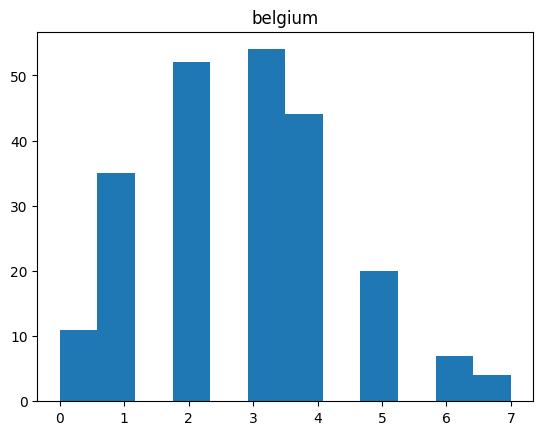

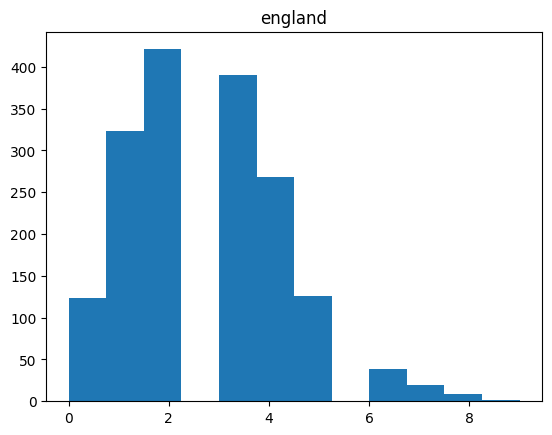

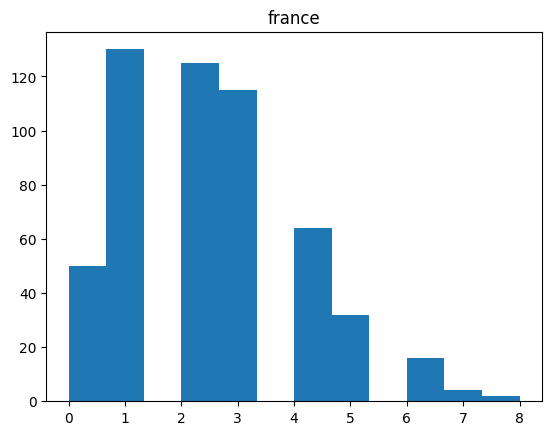

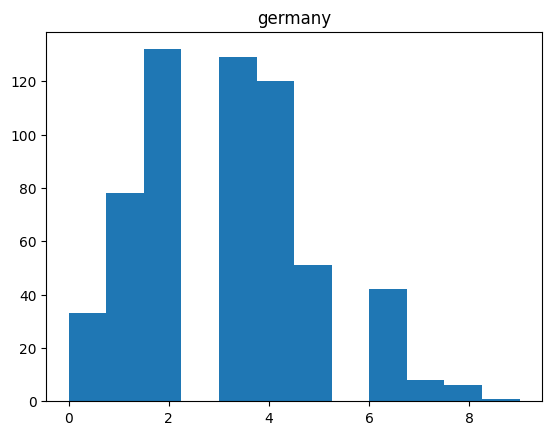

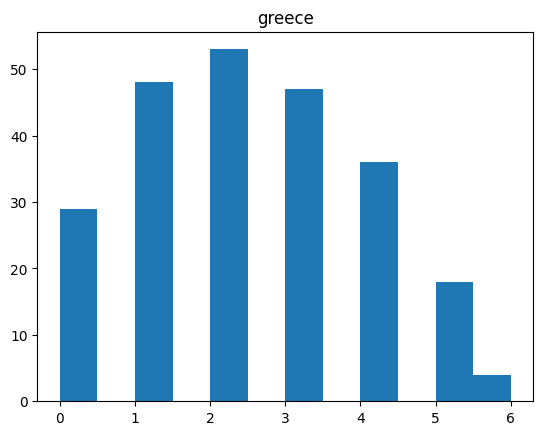

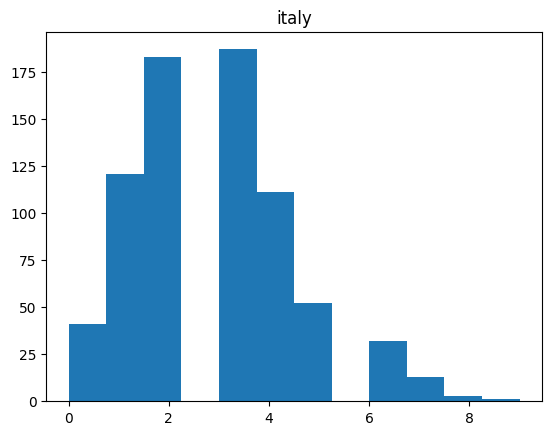

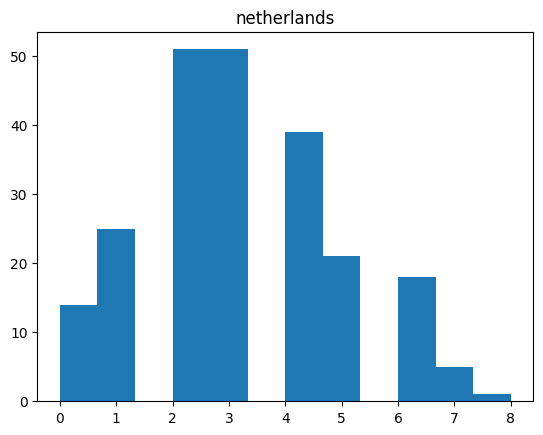

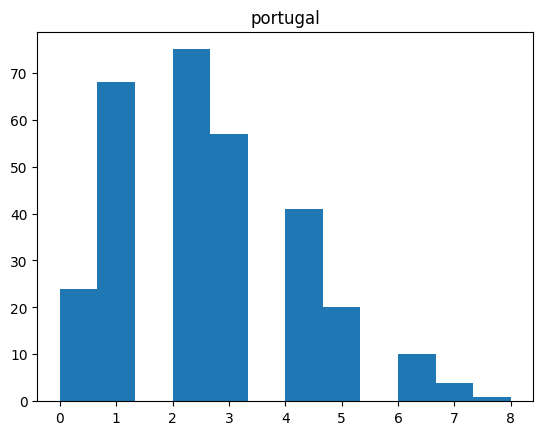

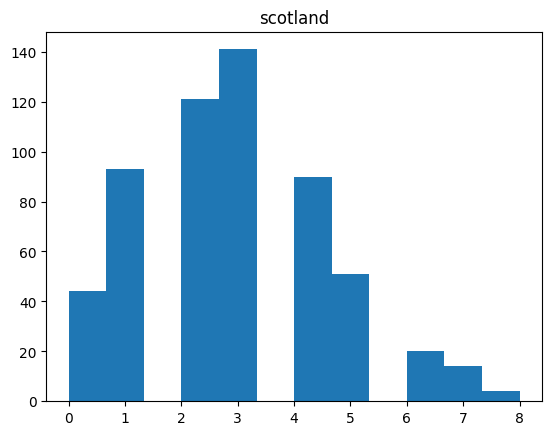

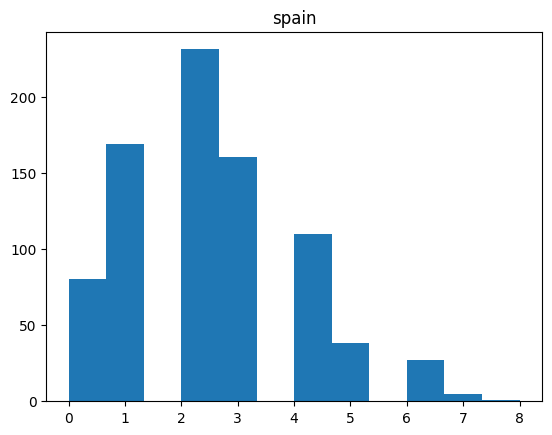

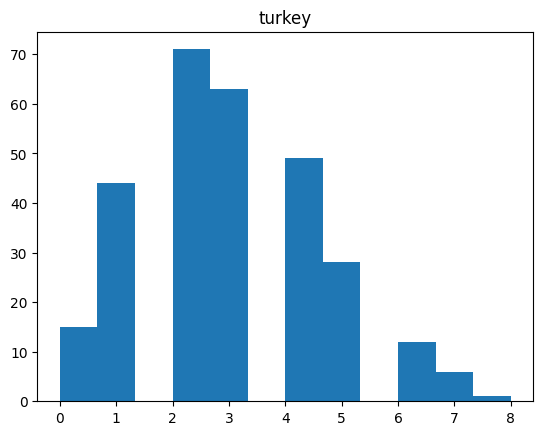

In [8]:
# plots (imo they show something close to poisson distribution)
import matplotlib.pyplot as plt 

a = pd.DataFrame
for country in dfs_train_reg_y:
    a = dfs_train_reg_y[country].value_counts()
    plt.hist(x=dfs_train_reg_y[country], bins=12)
    plt.title(country)
    plt.show()

## Regression task


#### Fitting various models, checking base measures -> model choice


In [9]:
bl_forests = {} # baseline random forest
p_regressors = {} # poisson regression
# tw_forests = {} # tweedie regression -> works on data (0;inf)
log_regressors = {} # logistic regression -> classification of 12 classes is a lot 
class_forests = {} # random forest classification -> not very good for this many classes; ordinal data
ada_regressors = {} # ada boost with default estimator - random forest regressor
pois_for_ada = {} # instances of poisson regressors to be used as estimators for ada boost
ada_pois = {} # ada boost with poisson regressors
bag_regressors = {} # bagging regressor with default estimator - random forest regressor 
pois_for_bag = {} # instances of poisson to be used with bagging regressor
bag_pois = {} # gabbing regressor using poisson ad estimator
grad_regressors = {} # gradient boost

In [10]:
for country in dfs_train_reg_X:
    bl_forests[country] = RandomForestRegressor(n_estimators=186, criterion="squared_error", max_depth=10)
    p_regressors[country] = PoissonRegressor(max_iter=100, solver='newton-cholesky')
    # tw_forests[country] = TweedieRegressor(power=3, solver='newton-cholesky')
    log_regressors[country] = LogisticRegression(solver='newton-cholesky', random_state=42)
    class_forests[country] = RandomForestClassifier(n_estimators=186, max_depth=10)
    ada_regressors[country] = AdaBoostRegressor(loss='square', random_state=42)
    pois_for_ada[country] = PoissonRegressor(max_iter=100, solver='newton-cholesky')
    ada_pois[country] = AdaBoostRegressor(estimator=pois_for_ada[country], loss='square', random_state=42)
    bag_regressors[country] = BaggingRegressor(bootstrap=False, random_state=42)
    pois_for_bag[country] = PoissonRegressor(max_iter=100, solver='newton-cholesky')
    bag_pois[country] = BaggingRegressor(estimator=pois_for_bag[country], bootstrap=False, random_state=42)
    grad_regressors[country] = GradientBoostingRegressor(random_state=42)

In [11]:
for country in dfs_train_reg_X:
    print("fitting ", country)
    bl_forests[country].fit(X=dfs_train_reg_X[country], y=dfs_train_reg_y[country])
    p_regressors[country].fit(X=dfs_train_reg_X[country], y=dfs_train_reg_y[country])
    # tw_forests[country].fit(X=dfs_train_reg_X[country], y=dfs_train_reg_y[country])
    log_regressors[country].fit(X=dfs_train_reg_X[country], y=dfs_train_reg_y[country])
    class_forests[country].fit(X=dfs_train_reg_X[country], y=dfs_train_reg_y[country])
    ada_regressors[country].fit(X=dfs_train_reg_X[country], y=dfs_train_reg_y[country])
    ada_pois[country].fit(X=dfs_train_reg_X[country], y=dfs_train_reg_y[country])
    bag_regressors[country].fit(X=dfs_train_reg_X[country], y=dfs_train_reg_y[country])
    bag_pois[country].fit(X=dfs_train_reg_X[country], y=dfs_train_reg_y[country])
    grad_regressors[country].fit(X=dfs_train_reg_X[country], y=dfs_train_reg_y[country])

In [12]:
# for country in dfs_train_reg_X:
    # print("predicting ", country)
    bl_prediction = bl_forests[country].predict(dfs_valid_reg_X[country])
    print("baseline forest mse of ", country, ":\t", MSE(bl_prediction, dfs_valid_reg_y[country]))
    pr_prediction = [int(item) for item in p_regressors[country].predict(dfs_valid_reg_X[country])]
    print("poisson regressor MSE of ", country, ":\t", MSE(pr_prediction, dfs_valid_reg_y[country]))
    print("poisson regressor MAE of ", country, ":\t", MAE(pr_prediction, dfs_valid_reg_y[country]))
    # tw_prediction = tw_forests[country].predict(dfs_valid_reg_X[country])
    # print("tweedie regression MSE ", country, ": ", MSE(tw_prediction, dfs_valid_reg_y[country]))
    log_prediction = [int(item) for item in log_regressors[country].predict(dfs_valid_reg_X[country])]
    print("logistic regression mse of ", country, ":\t", MSE(log_prediction, dfs_valid_reg_y[country]))
    cl_prediction = [int(item) for item in class_forests[country].predict(dfs_valid_reg_X[country])]
    print("classification model mse of ", country, ":\t", MSE(cl_prediction, dfs_valid_reg_y[country]))
    ada_prediction = [int(item) for item in ada_regressors[country].predict(dfs_valid_reg_X[country])]
    print("ada boost model mse of ", country, ":\t", MSE(ada_prediction, dfs_valid_reg_y[country]))
    ada_pois_prediction = [int(item) for item in grad_regressors[country].predict(dfs_valid_reg_X[country])]
    print("ada poisson model mse of ", country, ":\t", MSE(ada_pois_prediction, dfs_valid_reg_y[country]))
    bag_prediction = [int(item) for item in bag_regressors[country].predict(dfs_valid_reg_X[country])]
    print("bagging regressor mse of ", country, ":\t", MSE(bag_prediction, dfs_valid_reg_y[country]))
    bag_pois_prediction = [int(item) for item in bag_pois[country].predict(dfs_valid_reg_X[country])]
    print("bagging poisson regressor mse of ", country, ":\t", MSE(bag_pois_prediction, dfs_valid_reg_y[country]))
    print("bagging poisson regressor mae of ", country, ":\t", MAE(bag_pois_prediction, dfs_valid_reg_y[country]))
    grad_prediction = [int(item) for item in grad_regressors[country].predict(dfs_valid_reg_X[country])]
    print("gradient boost mse of ", country, ":\t", MSE(grad_prediction, dfs_valid_reg_y[country]))
    print("----------------------")
    # print(min([MSE(bl_prediction, dfs_valid_reg_y[country]),
    #            MSE(pr_prediction, dfs_valid_reg_y[country]),
    #            MSE(tw_prediction, dfs_valid_reg_y[country]),
    #            MSE(per_prediction, dfs_valid_reg_y[country]),
    #            MSE(log_prediction, dfs_valid_reg_y[country]),
    #            MSE(cl_prediction, dfs_valid_reg_y[country]),
    #            MSE(ada_prediction, dfs_valid_reg_y[country]),
    #            MSE(bag_prediction, dfs_valid_reg_y[country]),
    #            MSE(bag_pois_prediction, dfs_valid_reg_y[country]),
    #            MSE(grad_prediction, dfs_valid_reg_y[country])
    # ]))
    # print("----------------------")

#### Random search


In [13]:
param_grid = {
    'max_iter':[i for i in range(50,400)],
    'alpha':[i for i in range(1, 5)],
    'warm_start':[True, False] # whether to reuse solution of the previous fit
}

estimators = {}
models = {}
best = {}
best_estims = {}

In [14]:
for country in dfs_train_reg_X:
    estimators[country] = PoissonRegressor(solver='newton-cholesky')

In [15]:
for country in dfs_train_reg_X:
    print("random searching", country)
    models[country] = RandomizedSearchCV(estimator=estimators[country], param_distributions=param_grid,
                                         n_iter=30, cv=5, error_score='raise', verbose=3)

random searching belgium
random searching england
random searching france
random searching germany
random searching greece
random searching italy
random searching netherlands
random searching portugal
random searching scotland
random searching spain
random searching turkey


In [16]:
for country in models:
    models[country].fit(X=dfs_train_reg_X[country], y=dfs_train_reg_y[country])
    best[country] = models[country].best_params_
    print("-------------")
    print("best params for country", country, ": ", best[country])
    print("-------------")
    best_estims[country] = models[country].best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END alpha=3, max_iter=330, warm_start=True;, score=-0.097 total time=   0.0s
[CV 2/5] END alpha=3, max_iter=330, warm_start=True;, score=-0.023 total time=   0.0s
[CV 3/5] END alpha=3, max_iter=330, warm_start=True;, score=-0.018 total time=   0.0s
[CV 4/5] END alpha=3, max_iter=330, warm_start=True;, score=-0.073 total time=   0.0s
[CV 5/5] END alpha=3, max_iter=330, warm_start=True;, score=-0.026 total time=   0.0s
[CV 1/5] END alpha=2, max_iter=202, warm_start=False;, score=-0.099 total time=   0.0s
[CV 2/5] END alpha=2, max_iter=202, warm_start=False;, score=-0.032 total time=   0.0s
[CV 3/5] END alpha=2, max_iter=202, warm_start=False;, score=-0.025 total time=   0.0s
[CV 4/5] END alpha=2, max_iter=202, warm_start=False;, score=-0.068 total time=   0.0s
[CV 5/5] END alpha=2, max_iter=202, warm_start=False;, score=-0.030 total time=   0.0s
[CV 1/5] END alpha=2, max_iter=355, warm_start=True;, score=-0.099 total 

In [17]:
for country in models:
    preds = best_estims[country].predict(dfs_valid_reg_X[country])
    print("Validation MSE of country ", country, " with random search params: ", MSE(dfs_valid_reg_y[country], preds))
    print("Validation MAE of country ", country, " with random search params: ", MAE(dfs_valid_reg_y[country], preds))

Validation MSE of country  belgium  with random search params:  2.7454834864130686
Validation MAE of country  belgium  with random search params:  1.321845700268778
Validation MSE of country  england  with random search params:  2.5336870655696266
Validation MAE of country  england  with random search params:  1.2868599702156718
Validation MSE of country  france  with random search params:  2.484621363343011
Validation MAE of country  france  with random search params:  1.256458277020896
Validation MSE of country  germany  with random search params:  2.6534416495561497
Validation MAE of country  germany  with random search params:  1.2836726515337762
Validation MSE of country  greece  with random search params:  2.6418165899902615
Validation MAE of country  greece  with random search params:  1.3027331025819742
Validation MSE of country  italy  with random search params:  2.550628048589845
Validation MAE of country  italy  with random search params:  1.2951400345539041
Validation MSE o

In [18]:
# export predictions
X_dfs = {}
preds_dfs = {}

for country in best_estims:
    for column in dfs_test_reg_X[country].columns:
        if column.startswith('league'):
            name = f"{country}_{column[-1]}"
            X_dfs[name] = dfs_test_reg_X[country][dfs_test_reg_X[country][column]]

for country in X_dfs:
    print("predicting",  country, " using regressor", country[:-2])
    preds_dfs[country] = pd.DataFrame([int(item) for item in best_estims[country[:-2]].predict(X_dfs[country])])
    # print(preds_dfs[country])
    preds_dfs[country].to_csv(f"data/predictions_new/{country}.csv", index=False, header=False)

predicting belgium_1  using regressor belgium
predicting england_0  using regressor england
predicting england_1  using regressor england
predicting england_2  using regressor england
predicting england_3  using regressor england
predicting france_1  using regressor france
predicting france_2  using regressor france
predicting germany_1  using regressor germany
predicting germany_2  using regressor germany
predicting greece_1  using regressor greece
predicting italy_1  using regressor italy
predicting italy_2  using regressor italy
predicting netherlands_1  using regressor netherlands
predicting portugal_1  using regressor portugal
predicting scotland_0  using regressor scotland
predicting scotland_1  using regressor scotland
predicting scotland_2  using regressor scotland
predicting scotland_3  using regressor scotland
predicting spain_1  using regressor spain
predicting spain_2  using regressor spain
predicting turkey_1  using regressor turkey
